# Euclid Q1: SPE catalogs

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 SPE catalogs.
- Understand what SPE catalogs are available and how to view the columns in those catalogs.
- How to query with ADQL in the SPE lines catalog to find strong H-alpha detections.
- How to make a plot the detected line features over the 1D spectra.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA.
The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe.
The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals.
These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields:
Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.


Among the data products included in the Q1 release are multiple catalogs created by the SPE Processing Function.
This notebook provides an introduction to these SPE catalogs.
If you have questions about this notebook, please contact the [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

## Imports

```{important}
We rely on ``astroquery`` features that have been recently added, so please make sure you have version v0.4.10 or newer installed.
```

In [1]:
# Uncomment the next line to install dependencies if needed
# !pip install matplotlib astropy 'astroquery>=0.4.10'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import QTable
from astropy import units as u
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch, quantity_support

from astroquery.ipac.irsa import Irsa

## 1. Find the MER Tile ID that corresponds to a given RA and Dec

In this case, choose the coordinates from the first notebook to save time downloading the MER mosaic. Search a radius of 1.5 arcminutes around these coordinates.

In [3]:
search_radius = 10 * u.arcsec
coord = SkyCoord.from_name('HD 168151')

```{tip}
The IRSA SIA collections can be listed using using the ``list_collections`` method, we can filter on the ones containing "euclid" in the collection name:

    Irsa.list_collections(filter='euclid')
```

### Use IRSA to search for all Euclid data on this target

This searches specifically in the ``euclid_DpdMerBksMosaic`` collection which is the MER images and catalogs.

In [4]:
image_table = Irsa.query_sia(pos=(coord, search_radius), collection='euclid_DpdMerBksMosaic')

This table lists all MER mosaic images available in this search position. These mosaics include the Euclid VIS, Y, J, H images, as well as ground-based telescopes which have been put on the same pixel scale. For more information, see the [Euclid documentation at IPAC](https://euclid.caltech.edu/page/euclid-faq-tech/).

Note that there are various image types are returned as well, we filter out the `science` images from these:

In [5]:
science_images = image_table[image_table['dataproduct_subtype'] == 'science']
science_images

s_ra,s_dec,facility_name,instrument_name,dataproduct_subtype,calib_level,dataproduct_type,energy_bandpassname,energy_emband,obs_id,s_resolution,em_min,em_max,em_res_power,proposal_title,access_url,access_format,access_estsize,t_exptime,s_region,obs_collection,obs_intent,algorithm_name,facility_keywords,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,target_name,target_type,target_standard,target_moving,target_keywords,obs_release_date,s_xel1,s_xel2,s_pixel_scale,position_timedependent,t_min,t_max,t_resolution,t_xel,obs_publisher_did,s_fov,em_xel,pol_states,pol_xel,cloud_access,o_ucd,upload_row_id
deg,deg,,,,,,,,,arcsec,m,m,,,,,kbyte,s,deg,,,,,,,,,,,,,,,,,,arcsec,,d,d,s,,,deg,,,,,,
float64,float64,object,object,object,int16,object,object,object,object,float64,float64,float64,float64,object,object,object,int64,float64,object,object,object,object,object,object,bool,object,object,object,object,object,bool,bool,object,object,int64,int64,float64,bool,float64,float64,float64,int64,object,float64,int64,object,int64,object,object,int64
273.74061163858784,64.50001388888538,Euclid,NISP,science,3,image,H,Infrared,102158277_NISP,0.1026,1.372e-06,2e-06,2.7,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/H,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-H_TILE102158277-797A7D_20241025T122514.635323Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,Euclid,NISP,science,3,image,J,Infrared,102158277_NISP,0.094,1.146e-06,1.372e-06,5.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102158277-DA51EA_20241025T122533.612365Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/J,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-J_TILE102158277-DA51EA_20241025T122533.612365Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,Euclid,NISP,science,3,image,Y,Infrared,102158277_NISP,0.0878,9.2e-07,1.146e-06,4.6,Euclid on-the-fly,https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits,image/fits,1474566,--,POLYGON ICRS 274.366109291086 64.76536207691132 273.11511335805267 64.76536180261205 273.1272020139886 64.23206348982802 274.3540218940251 64.23206375763488 274.366109291086 64.76536207691132,euclid_DpdMerBksMosaic,SCIENCE,mosaic,,,--,,,,,field,--,False,,2025-05-01 00:00:00,19200,19200,0.100000000000008,False,--,--,--,--,ivo://irsa.ipac/euclid_DpdMerBksMosaic?102158277_NISP/Y,0.533333333333376,--,,--,"{""aws"": {""bucket_name"": ""nasa-irsa-euclid-q1"", ""key"":""q1/MER/102158277/NISP/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102158277-1FE0D9_20241025T122512.777703Z_00.00.fits"", ""region"": ""us-east-1""}}",,1
273.74061163858784,64.50001388888538,Pan-STARRS,Pan-STARRS,science,3,image,I,Optical,102158277_PANSTARRS,1.11,6.78317e-07,8.30624e-07,5.0,Euclid on-the-fly,https://

### Choose the VIS image and pull the Tile ID

Extract the tile ID from the ``obs_id`` column. The values in this column are made a combination of the 9 digit tile ID and the abbreviation of the instrument.

In [6]:
tileID = science_images[science_images['energy_bandpassname'] == 'VIS']['obs_id'][0][:9]

print(f'The MER tile ID for this object is : {tileID}')

The MER tile ID for this object is : 102158277


## 2. Download SPE catalog from IRSA directly to this notebook

Search for all tables in IRSA labeled as euclid

In [7]:
Irsa.list_catalogs(filter='euclid')

{'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog'}

In [8]:
table_mer = 'euclid_q1_mer_catalogue'
table_galaxy_candidates = 'euclid_q1_spectro_zcatalog_spe_galaxy_candidates'
table_1dspectra = 'euclid.objectid_spectrafile_association_q1'
table_lines = 'euclid_q1_spe_lines_line_features'

### Learn some information about the table:
- How many columns are there?
- List the column names

In [9]:
columns_info = Irsa.list_columns(catalog=table_mer)
print(len(columns_info))

477


In [10]:
Irsa.list_columns(catalog=table_1dspectra, full=True)

column_index,schema_name,irsa_schema_name,table_name,column_name,description,unit,ucd,utype,datatype,arraysize,size,principal,indexed,std,irsa_label,xtype,irsa_format,irsa_ref
int32,object,object,object,object,object,object,object,object,object,int32,int32,int32,int32,int32,object,object,object,object
1,euclid,euclid,euclid.objectid_spectrafile_association_q1,objectid,Euclid Object ID,,,,long,1,1,1,0,0,objectid,,20d,
2,euclid,euclid,euclid.objectid_spectrafile_association_q1,tileid,Euclid Tile ID,,,,long,1,1,1,0,0,tileid,,20d,
3,euclid,euclid,euclid.objectid_spectrafile_association_q1,path,Relative path to combined spectrum file containing spectrum for objectid,,,,char,1,1,1,0,0,path,,151.151s,
4,euclid,euclid,euclid.objectid_spectrafile_association_q1,hdu,HDU of combined spectrum file containing spectrum for objectid,,,,long,1,1,1,0,0,hdu,,20d,
5,euclid,euclid,euclid.objectid_spectrafile_association_q1,obs_publisher_did,VO identifier,,,,char,1,1,1,0,0,obs_publisher_did,,151.151s,
6,euclid,euclid,euclid.objectid_spectrafile_association_q1,bandpass_name,Bandpass name,,,,char,1,1,1,0,0,bandpass_name,,12.12s,
7,euclid,euclid,euclid.objectid_spectrafile_association_q1,label,Label,,,,char,1,1,1,0,0,label,,12.12s,


In [11]:
# Full list of columns and their description
columns_info

{'flux_g_ext_hsc_templfit': 'Gext HSC band source template fitting flux (TPHOT measurement)',
 'flux_z_ext_hsc_templfit': 'Zext HSC band source template fitting flux (TPHOT measurement)',
 'fluxerr_y_templfit': 'NIR Y band source template fitting flux error (TPHOT measurement)',
 'fluxerr_j_templfit': 'NIR J band source template fitting flux error (TPHOT measurement)',
 'fluxerr_h_templfit': 'NIR H band source template fitting flux error (TPHOT measurement)',
 'fluxerr_u_ext_decam_templfit': 'Uext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_g_ext_decam_templfit': 'Gext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_r_ext_decam_templfit': 'Rext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_i_ext_decam_templfit': 'Iext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_z_ext_decam_templfit': 'Zext DECam band source template fitting flux error (TPHOT measurement)',
 

## Find some objects with spectra in our tileID

We specify the following conditions on our search:
- Signal to noise ratio column (_gf = gaussian fit) should be greater than 5
- We want to detect H-alpha.
- We choose in which tileID to search, usign the tileID from the first notebook.
- Choose spectroscopic redshift (spe_z) between 1.4 and 1.6 and spe_z_prob greater than 0.999
- H-alpha line flux should be more than 2x10^16 erg s^-1 cm^-2
- Join the lines and galaxy candidates tables on object_id and spe_rank

Finally we sort the data by descending spe_line_snr_gf to have the largest SNR H-alpha lines detected at the top.

In [12]:
adql_query = ("SELECT DISTINCT mer.object_id,mer.ra, mer.dec, mer.tileid, mer.flux_y_templfit, "
    "lines.spe_line_snr_gf,lines.spe_line_snr_di, lines.spe_line_name, lines.spe_line_central_wl_gf, "
    "lines.spe_line_ew_gf, galaxy.spe_z_err, galaxy.spe_z,galaxy.spe_z_prob, "
    "lines.spe_line_flux_gf, lines.spe_line_flux_err_gf "
    f"FROM {table_mer} AS mer "
    f"JOIN {table_lines} AS lines "
    "ON mer.object_id = lines.object_id "
    f"JOIN {table_galaxy_candidates} AS galaxy "
    "ON lines.object_id = galaxy.object_id AND lines.spe_rank = galaxy.spe_rank "
    "WHERE lines.spe_line_snr_gf >5 "
    "AND lines.spe_line_name = 'Halpha' "
    f"AND mer.tileid = {tileID} "
    "AND galaxy.spe_z_prob > 0.99 "
    "AND galaxy.spe_z BETWEEN 1.4 AND 1.6 "
    "AND lines.spe_line_flux_gf > 2E-16 "
    "ORDER BY lines.spe_line_snr_gf DESC ")

# Use TAP with this ADQL string
result_table = Irsa.query_tap(adql_query).to_table()


### Choose an object of interest, lets look at an object with a strong Halpha line detected with high SNR.

In [13]:
obj_id = 2737659721646729968

obj_row = result_table[(result_table['object_id'] == obj_id)]

obj_row

object_id,ra,dec,tileid,flux_y_templfit,spe_line_snr_gf,spe_line_snr_di,spe_line_name,spe_line_central_wl_gf,spe_line_ew_gf,spe_z_err,spe_z,spe_z_prob,spe_line_flux_gf,spe_line_flux_err_gf
,deg,deg,,uJy,,,,,,,,,,
int64,float64,float64,int64,float32,float32,float32,object,float32,float32,float32,float32,float32,float32,float32
2737659721646729968,273.76597217,64.67299689,102158277,49.94940948,8.55331707,6.110000134,Halpha,16741.00195,-24.14109612,0.0004555544874,1.553462625,0.9971491694,2.706930158e-16,6.770828671e-17


### Pull the spectrum of this object

In [14]:
adql_object = f"SELECT *  FROM {table_1dspectra}  WHERE objectid = {obj_id}"

result_table2 = Irsa.query_tap(adql_object).to_qtable()

### The following steps to read in the spectrum follows the 3_Euclid_intro_1D_spectra notebook.

In [15]:
spectrum_path = f"https://irsa.ipac.caltech.edu/{result_table2['path'][0]}"
spectrum_path

'https://irsa.ipac.caltech.edu/api/spectrumdm/convert/euclid/q1/SIR/102158277/EUC_SIR_W-COMBSPEC_102158277_2024-11-05T15:54:09.376202Z.fits?dataset_id=euclid_combspec&hdu=1179'

In [16]:
spectrum = QTable.read(spectrum_path)

### Now the data are read in, plot the spectrum with the H-alpha line labeled

```{tip}
As we use astropy.visualization's ``quantity_support``, matplotlib automatically picks up the axis units from the quantities we plot.
```

In [17]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7feec0906810>

Text(0.5, 1.0, 'Object ID 2737659721646729968')

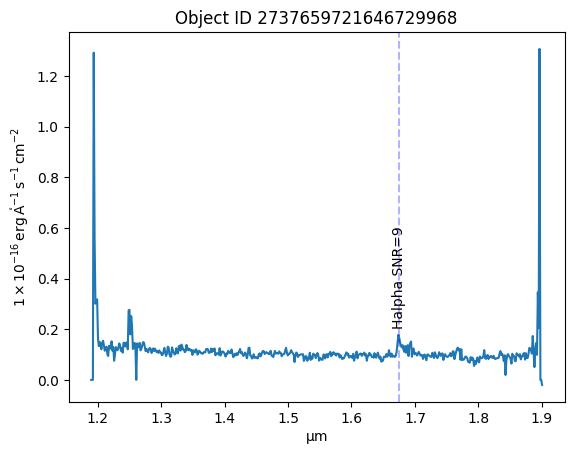

In [18]:
# Note that the units are missing from the lines table, we manually add Angstrom
line_wavelengths = obj_row['spe_line_central_wl_gf'] * u.angstrom
line_names = obj_row['spe_line_name']
snr_gf = obj_row['spe_line_snr_gf']

plt.plot(spectrum['WAVELENGTH'].to(u.micron), spectrum['SIGNAL'])

for wl, name, snr in zip(np.atleast_1d(line_wavelengths), np.atleast_1d(line_names), np.atleast_1d(snr_gf)):
    plt.axvline(wl, color='b', linestyle='--', alpha=0.3)
    plt.text(wl, .2, name+' SNR='+str(round(snr)), rotation=90, ha='center', va='bottom', fontsize=10)

plt.title(f'Object ID {obj_id}')

## About this Notebook

**Author**: Tiffany Meshkat, Anahita Alavi, Anastasia Laity, Andreas Faisst, Brigitta Sipőcz, Dan Masters, Harry Teplitz, Jaladh Singhal, Shoubaneh Hemmati, Vandana Desai, Troy Raen

**Updated**: 2025-09-23

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.